In [4]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

D:\python36\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [6]:
# Import Dataset
df = pd.read_csv('CSR_title_text.csv', error_bad_lines=False);
df.head()# Convert to list




,CSR_no,SR_title
0,143979,When will earfcns greater than 65535 be suppor...
1,144595,SR periodicity
2,144653,LTE Stack Issue with CLI
3,146023,L2 crash (Segmentation fault) when originating...
4,146100,L2 crash after pumping UL data from a UE.


In [7]:
data = df.SR_title.values.tolist()
df.dtypes

CSR_no       int64
SR_title    object
dtype: object

In [8]:
# Remove special characters
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['When will earfcns greater than 65535 be supported ?']


In [9]:
#Tokenize words and Clean-up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['when', 'will', 'earfcns', 'greater', 'than', 'be', 'supported']]


In [10]:
# Build the bigram and trigram models
#N-Gram model
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
print(bigram[data_words])

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])
print(bigram_mod[data_words[0]])

D:\python36\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['when', 'will', 'earfcns', 'greater_than', 'be', 'supported']
['when', 'will', 'earfcns', 'greater_than', 'be', 'supported']


In [11]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

#Issue - not able to install spacy
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
len(data_words)
print(data_words_nostops[13:14])

[['rohc', 'working', 'crash', 'happened', 'rohc', 'enable']]


In [13]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
print(data_words_bigrams[:1])

[['earfcns', 'greater', 'supported']]


In [14]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['earfcns', 'great', 'support']]


In [15]:
#Dictionary and Corpus needed for Topic Modeling
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

In [16]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [17]:
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [18]:
id2word[0]

'earfcns'

In [19]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[13:14]]

[[('crash', 1), ('work', 1), ('enable', 1), ('happen', 1), ('rohc', 2)]]

In [25]:
#Building the Topic Model
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [26]:
#View the topics in LDA model
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.084*"redmine" + 0.037*"ospf" + 0.027*"ip" + 0.027*"event" + 0.026*"ospfv" '
  '+ 0.021*"isis" + 0.021*"change" + 0.019*"fsu" + 0.016*"send" + '
  '0.016*"drop_ig"'),
 (1,
  '0.048*"error" + 0.044*"show" + 0.040*"command" + 0.036*"test" + '
  '0.032*"result" + 0.032*"eoam_dev" + 0.032*"tlvs" + 0.029*"ipv" + '
  '0.027*"symbolperiod" + 0.018*"display"'),
 (2,
  '0.081*"iss" + 0.047*"route" + 0.030*"port" + 0.027*"interface" + '
  '0.022*"configure" + 0.020*"vlan" + 0.017*"fail" + 0.016*"configuration" + '
  '0.012*"entry" + 0.012*"crash"'),
 (3,
  '0.058*"loopback" + 0.040*"state" + 0.033*"issue" + 0.033*"remote" + '
  '0.032*"behavior" + 0.029*"expect" + 0.027*"eoam" + 0.018*"enable" + '
  '0.018*"session" + 0.013*"query"')]


In [27]:
#Compute Model Perplexity and Coherence Score
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -7.688553658700321


In [28]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.32502831739370003


In [29]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

D:\python36\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.329872  0.088254       1        1  33.394806
0     -0.193504  0.253305       2        1  25.463223
3     -0.049793 -0.262829       3        1  22.612007
1     -0.086575 -0.078730       4        1  18.529968, topic_info=     Category         Freq          Term        Total  loglift  logprob
term                                                                   
77    Default  1347.000000           iss  1347.000000  30.0000  30.0000
1396  Default  1054.000000       redmine  1054.000000  29.0000  29.0000
326   Default   651.000000      loopback   651.000000  28.0000  28.0000
520   Default   772.000000         route   772.000000  27.0000  27.0000
75    Default   442.000000         error   442.000000  26.0000  26.0000
62    Default   405.000000          show   405.000000  25.0000  25.0000
84    Default   448.000000         state   448.000000  24.0000  24.0000
280   Default   465.000000          ospf   465.000000  23.0000  23.0000
244   Default   366.000000       command   366.000000  22.0000  22.0000
54    Default   333.000000          test   333.000000  21.0000  21.0000
6     Default   374.000000         issue   374.000000  20.0000  20.0000
752   Default   366.000000        remote   366.000000  19.0000  19.0000
206   Default   493.000000          port   493.000000  18.0000  18.0000
685   Default   359.000000      behavior   359.000000  17.0000  17.0000
667   Default   298.000000        result   298.000000  16.0000  16.0000
202   Default   454.000000     interface   454.000000  15.0000  15.0000
551   Default   328.000000        expect   328.000000  14.0000  14.0000
4458  Default   304.000000          tlvs   304.000000  13.0000  13.0000
61    Default   343.000000            ip   343.000000  12.0000  12.0000
506   Default   341.000000         event   341.000000  11.0000  11.0000
4499  Default   317.000000      eoam_dev   317.000000  10.0000  10.0000
428   Default   264.000000           ipv   264.000000   9.0000   9.0000
1564  Default   322.000000         ospfv   322.000000   8.0000   8.0000
260   Default   364.000000     configure   364.000000   7.0000   7.0000
4498  Default   318.000000          eoam   318.000000   6.0000   6.0000
352   Default   269.000000          isis   269.000000   5.0000   5.0000
32    Default   266.000000        change   266.000000   4.0000   4.0000
358   Default   323.000000          vlan   323.000000   3.0000   3.0000
4691  Default   296.000000  symbolperiod   296.000000   2.0000   2.0000
1232  Default   235.000000           fsu   235.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
54     Topic4   332.643524          test   333.392242   1.6835  -3.3166
428    Topic4   264.086487           ipv   264.772858   1.6832  -3.5474
667    Topic4   297.992920        result   298.984863   1.6825  -3.4266
338    Topic4   168.823502       display   169.501312   1.6818  -3.9948
603    Topic4   157.324188           bug   158.039307   1.6812  -4.0654
550    Topic4   149.288849       default   149.982834   1.6811  -4.1178
5      Topic4   141.623642           cli   142.293488   1.6811  -4.1705
251    Topic4   132.062515           ldp   132.736435   1.6807  -4.2404
24     Topic4   102.620476          peer   103.339249   1.6788  -4.4926
339    Topic4    95.195755           run    95.863007   1.6788  -4.5678
247    Topic4    88.495583        output    89.173691   1.6781  -4.6407
313    Topic4    83.986359          mode    84.662392   1.6778  -4.6930
1463   Topic4   105.570930        repeat   106.452538   1.6775  -4.4643
132    Topic4    76.038170        number    76.724937   1.6768  -4.7925
874    Topic4    81.837357           arp    82.596336   1.6765  -4.7190
328    Topic4    72.693840      database    73.368774   1.6765  -4.8374
1493   Topic4    77.478058  redistribute    78.224434   1.6762  -4.7737
314    Topic4    70.361374      p

In [30]:
#Building LDA Mallet Model
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

import os
os.environ.update({'MALLET_HOME': r'C:\mallet-2.0.8'})

mallet_path = 'C:/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [31]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

[(18,
  [('redmine', 0.11330861145447053),
   ('clear', 0.03996703749484961),
   ('switchover', 0.03914297486608982),
   ('card', 0.03543469303667079),
   ('execute', 0.03378656777915121),
   ('regression', 0.03378656777915121),
   ('reset', 0.03172641120725175),
   ('active', 0.025133910177173466),
   ('standby', 0.024309847548413678),
   ('test', 0.023897816234033788)]),
 (17,
  [('configuration', 0.1542056074766355),
   ('change', 0.14672897196261683),
   ('iss', 0.1322429906542056),
   ('link', 0.07383177570093458),
   ('csr', 0.03457943925233645),
   ('behavior', 0.016822429906542057),
   ('interval', 0.016822429906542057),
   ('update', 0.016355140186915886),
   ('nld_cr', 0.01588785046728972),
   ('perform_rate', 0.01588785046728972)]),
 (8,
  [('mme', 0.06870567375886524),
   ('request', 0.06693262411347518),
   ('pgw', 0.06648936170212766),
   ('release', 0.04343971631205674),
   ('update', 0.037677304964539006),
   ('code', 0.03679078014184397),
   ('snmp', 0.0354609929078014

In [26]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.43091987514671326


In [32]:
#How to find the optimal number of topics for LDA?
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [33]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=1, limit=10, step=1)

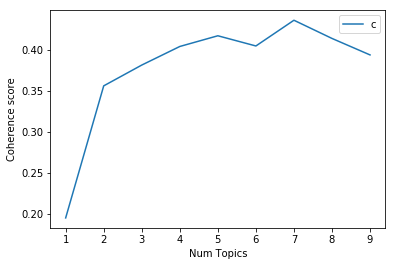

In [35]:
# Show graph
limit=10; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [36]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.1949
Num Topics = 2  has Coherence Value of 0.3559
Num Topics = 3  has Coherence Value of 0.3813
Num Topics = 4  has Coherence Value of 0.4039
Num Topics = 5  has Coherence Value of 0.417
Num Topics = 6  has Coherence Value of 0.4045
Num Topics = 7  has Coherence Value of 0.4359
Num Topics = 8  has Coherence Value of 0.4137
Num Topics = 9  has Coherence Value of 0.3936


In [37]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.119*"iss" + 0.060*"mpls" + 0.034*"tunnel" + 0.026*"port" + 0.022*"work" + '
  '0.021*"crash" + 0.021*"path" + 0.020*"node" + 0.018*"traffic" + '
  '0.018*"rsvp"'),
 (1,
  '0.062*"redmine" + 0.045*"route" + 0.038*"interface" + 0.038*"show" + '
  '0.035*"configure" + 0.034*"ospf" + 0.032*"ospfv" + 0.026*"command" + '
  '0.025*"configuration" + 0.023*"ip"'),
 (2,
  '0.034*"ldp" + 0.021*"vpn" + 0.016*"error" + 0.015*"vlan" + 0.014*"isis" + '
  '0.014*"_" + 0.014*"link" + 0.012*"time" + 0.012*"entry" + 0.012*"set"'),
 (3,
  '0.052*"issue" + 0.027*"change" + 0.017*"send" + 0.017*"support" + '
  '0.015*"query" + 0.014*"ue" + 0.013*"mme" + 0.013*"request" + 0.013*"pgw" + '
  '0.013*"enable"')]


In [32]:
#Finding the dominant topic in each sentence
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


In [33]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

In [34]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.0660,"iss, traffic, shut, mode, static, properly, vr...",When will earfcns greater than 65535 be suppor...
1,1,12.0,0.0694,"_, qos, call, network, egress, due, ingress, s...",SR periodicity
2,2,0.0,0.0648,"ue, mme, lte, epc, pgw, attach, hss, trace, da...",LTE Stack Issue with CLI
3,3,12.0,0.0965,"_, qos, call, network, egress, due, ingress, s...",L2 crash (Segmentation fault) when originating...
4,4,0.0,0.0957,"ue, mme, lte, epc, pgw, attach, hss, trace, da...",L2 crash after pumping UL data from a UE.
5,5,0.0,0.0804,"ue, mme, lte, epc, pgw, attach, hss, trace, da...",Load Information Not being exchanged from serv...
6,6,0.0,0.0660,"ue, mme, lte, epc, pgw, attach, hss, trace, da...",LTE max UL throughput
7,7,14.0,0.0673,"work, path, tunnel, rsvp, mpls, protection, en...",L1 attenuation through cli_ControllerApp is no...
8,8,18.0,0.0865,"crash, support, information, require, scenario...",LTE_WNM_GENERIC_INTERNAL_FAILURE in WNM scenario
9,9,13.0,0.0849,"change, set, stack, csr, question, snmp, rout,...",Configuration Parameter Changes


In [35]:
#Find the most representative document for each topic
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

In [36]:
# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2009,"ue, mme, lte, epc, pgw, attach, hss, trace, da...",LTE-PGW - SGW&PGW) Trace Statistics Report not...
1,1.0,0.1797,"issue, failure, file, code, module, customer, ...",Issue 0097601 Configure the different rule of ...
2,2.0,0.1567,"fail, time, switchover, bug, session, log, est...",Bug 469 [ISIS 3WAY HANDSHAKE] SCALABILITY Memo...
3,3.0,0.2231,"route, ospf, ipv, redmine, isis, router, regre...",Redmine235028 û [OSPFv3] ISIS level2 routes al...
4,4.0,0.1918,"iss, traffic, shut, mode, static, properly, vr...","ISS - ISS_MPLS_LDP: After port shut/no shut, L..."


In [37]:
#Topic distribution across documents

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,4.0,"iss, traffic, shut, mode, static, properly, vr...",606.0,0.0918
1,12.0,"_, qos, call, network, egress, due, ingress, s...",469.0,0.0710
2,0.0,"ue, mme, lte, epc, pgw, attach, hss, trace, da...",332.0,0.0503
3,12.0,"_, qos, call, network, egress, due, ingress, s...",272.0,0.0412
4,0.0,"ue, mme, lte, epc, pgw, attach, hss, trace, da...",262.0,0.0397
5,0.0,"ue, mme, lte, epc, pgw, attach, hss, trace, da...",324.0,0.0491
6,0.0,"ue, mme, lte, epc, pgw, attach, hss, trace, da...",290.0,0.0439
7,14.0,"work, path, tunnel, rsvp, mpls, protection, en...",284.0,0.0430
8,18.0,"crash, support, information, require, scenario...",305.0,0.0462
9,13.0,"change, set, stack, csr, question, snmp, rout,...",286.0,0.0433
